# Trabalho Computacional - Regressão Linear na Qualidade de Vinho

Alunos:

Gabriel Lima Sertão - 180113356

Israel Borges Roquete de Melo - 180033336

## Declaração de Módulos e Classes

Aqui estão os módulos e classes utilizados no trabalho:

In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
from d2l import tensorflow as d2l
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

class LinearRegressionData(d2l.DataModule):
    """ implementacao do DataModule pra dados externos

    Defined in :numref:`sec_synthetic-regression-data`"""
    def __init__(self,
                inputs,
                output,
                num_train=5197,
                num_val=1300,
                batch_size=32):
        super().__init__()
        self.save_hyperparameters(['tensor'])
        self.X = inputs
        self.y = output

    def get_dataloader(self, train):
        """Defined in :numref:`sec_synthetic-regression-data`"""
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader((self.X, self.y), train, i)


## Leitura do Arquivo e Pré-Processamento do Dados

Para o pré-processamento dos dados, o arquivo é aberto como um DataFrame; os parâmetros do tipo do vinho são substituídos por variáveis *dummy*; as entradas com valores vazios são substituídas pela média da coluna; a coluna de qualidade é alterada para classificar entre 1 e 7, ao invés de 3 e 9; Os canjuntos de treinamento e validação são separados; e o DataFrame é transformado em duas matrizes para instanciar a classe DataModule do d2l.

In [2]:

# Verifica se o arquivo CSV está na área de trabalho ( inserir o caminho até ele)
arquivo_csv = os.path.expanduser("winequalityN.csv")

# Verifique se o arquivo CSV existe
if not os.path.exists(arquivo_csv):
    print(f"O arquivo '{arquivo_csv}' não foi encontrado na área de trabalho.")
else:
    # Abra o arquivo CSV para leitura
    data = pd.read_csv(arquivo_csv)
    data = pd.get_dummies(data)
    data = data.fillna(data.mean())  #substitui células vazias pela média da coluna
    data['quality'] -= 2
    
    train_data, val_data = train_test_split(data, test_size=0.2)
    
    dataset = data.copy()

    outputs = dataset.pop('quality')
    outputs = tf.constant(outputs.to_numpy(dtype=float))
    
    inputs = dataset
    inputs = tf.constant(inputs.to_numpy(dtype=float))

    lr_data = LinearRegressionData(inputs, outputs, num_train=train_data.shape[0], num_val=val_data.shape[0] ,batch_size=32)

## Treinamento do Modelo

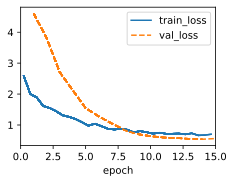

In [3]:
#definição do modelo de aprendizado e inicio do treinamento
model = d2l.LinearRegression(lr=2e-5)
trainer = d2l.Trainer(max_epochs=15)
trainer.fit(model, lr_data)

O modelo calcula os pesos (w) e (b) da regressão linear, que são salvos como hiperparâmetros do modelo, podendo ser acessados:

In [4]:

w, b = model.get_w_b()
wstring = ''
for i, elem in enumerate(w.reshape(1,13)[0]):
    wstring += f' {elem:.3f},'
print(f"w = {wstring[:-1]} \n\
b = {b[0]:.3f}")

w =  0.106, -0.003, 0.016, 0.004, -0.000, 0.011, 0.001, 0.027, 0.052, 0.017, 0.232, 0.015, 0.013 
b = 0.016


## Avaliação

Após o treinamento, os dados de avaliação são passados para a função `call()` do modelo de regressão, que retorna os resultados da predição. 

In [5]:
#preparo do DataFrame de dados de validação
val_dataset = val_data.copy()
Yo = tf.cast(val_dataset.pop('quality'), dtype=tf.float32)
val_dataset = tf.constant(val_dataset.to_numpy(dtype=float)) 

#chamada da função de predição
prediction = model.call(val_dataset)
prediction = tf.cast(prediction, dtype=tf.float32)

## Métricas de Avaliação

Os resultados do treinamento são avaliados por meio de:
- Erro Médio Absoluto (MAE), calculado pela norma $L_1$:
    $$
    L_{1} = \overline{y_{predição} - y_{real}}
    $$
- Função Custo, ou Erro Quadrático Médio (MSE):
  $$
    loss = L_{2} = \overline{(y_{predição} - y_{real})^2}
  $$
- Média das saídas esperadas (Preditor Trivial):
  $$
  \overline{y_{real}}
  $$

Previsões: [[3.8165038 3.749791  4.4956474 ... 3.5105207 3.5860205 3.8740132]] 
Valores Reais:[2. 4. 4. ... 4. 4. 4.] 
MAE: 0.6434264183044434 
MSE: 0.6861997246742249 
Média: 3.8183777127905185 

Correlação:                       fixed acidity  volatile acidity  citric acid  \
fixed acidity              1.000000          0.219918     0.323349   
volatile acidity           0.219918          1.000000    -0.377759   
citric acid                0.323349         -0.377759     1.000000   
residual sugar            -0.112219         -0.196578     0.142451   
chlorides                  0.298282          0.377122     0.039310   
free sulfur dioxide       -0.283237         -0.353055     0.133426   
total sulfur dioxide      -0.329409         -0.414706     0.195148   
density                    0.458941          0.271107     0.096307   
pH                        -0.251683          0.260283    -0.328354   
sulphates                  0.300225          0.225313     0.057564   
alcohol              

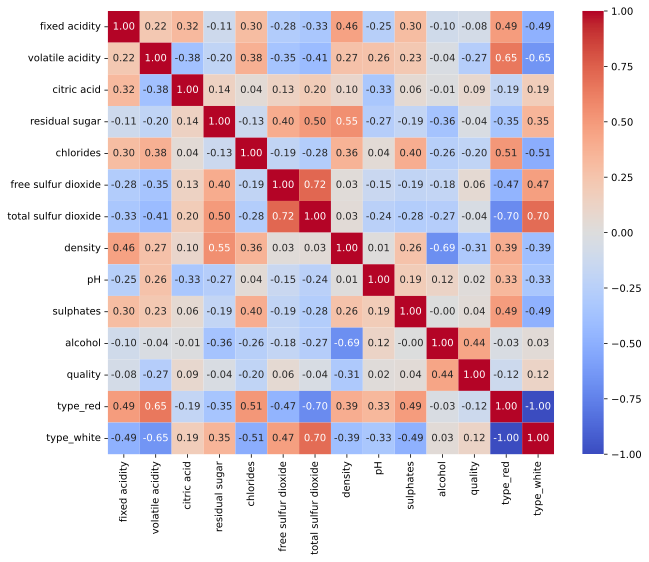

In [6]:
preditor_trivial = np.mean(outputs)
prediction = tf.transpose(prediction)

# Calcul0 do erro médio absoluto (MAE)
mae = np.mean(np.abs(prediction - Yo))

# Calculo do erro médio quadrático (MSE)
mse = model.loss(prediction, Yo)

correlation_matrix = data.corr() #Cálculo de correlação

print(f"Previsões: {prediction} \n\
Valores Reais:{Yo} \n\
MAE: {mae} \n\
MSE: {mse} \n\
Média: {preditor_trivial} \n\n\
Correlação: {correlation_matrix} \n\
")

#Mapa de calor das correlações dos dados, melhor visualização do que no print da matrix. Pode ser desconsiderado.
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()


## Classificação por Arredondamento

Arredondando os valores obtidos na predição para implementar um modelo de classificação, foi obtida uma taxa de acerto por volta dos 50%, que, quando comparada com um preditor trivial é apenas ligeiramente maior do que a taxa de acerto da média. No entanto, os dois tem performance muito maior que a do preditor aleatório.

In [7]:
def taxa_de_acerto(predicao, valores_reais):
    acc = predicao - valores_reais
    count = 0
    for elem in acc[0]:
        if elem == 0: 
            count += 1
    return count / Yo.shape[0]

class_prediction = []
for elem in prediction:
    class_prediction.append(np.round(elem))

acc_rate_predicao = taxa_de_acerto(class_prediction, Yo)

preditor_trivial = tf.cast(tf.constant(preditor_trivial, shape=(1, 1300)), dtype=tf.float32) 
preditor_trivial = np.round(preditor_trivial)

acc_rate_trivial = taxa_de_acerto (preditor_trivial, Yo)

preditor_aleatorio = tf.random.uniform((1, 1300), 1, 7, dtype=tf.int32)
preditor_aleatorio = tf.cast(preditor_aleatorio, dtype=tf.float32)

acc_rate_aleatorio = taxa_de_acerto (preditor_aleatorio, Yo)

print(f"Taxa de acerto do modelo: {acc_rate_predicao:.3f} \n\
Taxa de acerto do preditor trivial: {acc_rate_trivial:.3f}\n\
Taxa de acerto do preditor aleatorio: {acc_rate_aleatorio:.3f}")



Taxa de acerto do modelo: 0.462 
Taxa de acerto do preditor trivial: 0.418
Taxa de acerto do preditor aleatorio: 0.154


## Provocação

Um algoritmo de aprendizado de máquina pode ser considerado inteligente se ele for capaz de realizar tarefas complexas com um bom desempenho e generalizando para casos que ainda não tenha visto, ou, em um objetivo mais geral, mimetizar as habilidades cognitivas humanas.

A questão do algoritmo aprender ou não a classificar vinhos, pode ter várias interpretações. É inteligente seguindo os aspectos humanos? Talvez não, pois sua inteligência é delimitada ao seu espaço amostral, não seria possível classificar coisas que estivessem fora de sua área de atuação. Enquanto um humano *sommelier* pode aprender várias outras coisas além de sua profissão.

Agora, em um universo computacional, onde máquinas aprendem baseadas em linhas de códigos propostas, novas tecnologias que vão se aprimorando e melhorando seus outputs "automaticamente" podem ser consideradas inteligentes. Se um sistema recebe milhares de entradas e acerta a maioria de suas classificações, eu diria que foi capaz de aprender e cumpriu seu propósito, qual seria a diferença para um humano que faz a mesma coisa, em escala bem menor, também passível de erros? Confiaria a classificação do meu vinho a ele.

Mas é uma pergunta filosófica e que provávelmente não será respondida por este que escreve, tendo em vista que Turing fez a mesma pergunta em 1950 e ainda estamos buscando a resposta mais de 70 anos depois.